In [2]:
from config import API_KEY, API_SECRET, API_KEY_LIVE, API_SECRET_LIVE
import requests
import ccxt
from Connection_2 import CustomAlpaca
print(ccxt.exchanges)
alpaca_ms = CustomAlpaca(config={
    'apiKey': API_KEY,          # Alpaca API Key
    'secret': API_SECRET,       # Alpaca Secret Key
    'enableRateLimit': True
    })


Test market URL: https://data.{hostname}

fetch Request: alpaca GET https://data.alpaca.markets/v1beta3/crypto/us/bars?symbols=BTC%2FUSD&timeframe=1min RequestHeaders: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'APCA-PARTNER-ID': 'ccxt'} RequestBody: None

fetch Response: alpaca GET https://data.alpaca.markets/v1beta3/crypto/us/bars?symbols=BTC%2FUSD&timeframe=1min 200 ResponseHeaders: {'Date': 'Mon, 02 Dec 2024 03:50:41 GMT', 'Content-Type': 'application/json; charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding', 'X-Ratelimit-Limit': '200', 'X-Ratelimit-Remaining': '199', 'X-Ratelimit-Reset': '1733111441', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'X-Request-ID': '6bf51a1d0018e92c65542e78a423f57b', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Methods': 'GET, OPTIONS', 'Access-C

### Check if we can fetch OHLCV

In [3]:
# alpaca_ms.set_sandbox_mode(enabled=True) # 그냥 alpaca()는 위에 overriding을 하는듯 보였으나, ccxt,alpaca는 안됨

# print("Test market URL:", alpaca_ms.describe()['urls']['test']['market'])
# alpaca_ms.load_markets() # unnecessary but make it faster
# alpaca_ms.verbose = True

# alpaca_ms.fetch_ohlcv('BTC/USD', timeframe='1m')

### Check for Crypto Tickers

In [4]:
# Alpaca API endpoint for assets
url = 'https://api.alpaca.markets/v2/assets'

# Set headers with your API credentials
headers = {
    'Apca-Api-Key-Id': API_KEY_LIVE,
    'Apca-Api-Secret-Key': API_SECRET_LIVE
}

# Parameters to filter for crypto assets
params = {
    'asset_class': 'crypto'
}

# Make the request to the Alpaca API
response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    assets = response.json()
    # Filter for tradable assets and extract their symbols
    tradable_crypto_symbols = [asset['symbol'] for asset in assets if asset['tradable']]
    print("Tradable Crypto Tickers:", tradable_crypto_symbols)
else:
    print(f"Failed to retrieve assets: {response.status_code} - {response.text}")


Tradable Crypto Tickers: ['MKR/USD', 'AVAX/USD', 'LINK/USD', 'LTC/USD', 'SHIB/USD', 'SUSHI/USD', 'USDC/USD', 'USDT/USD', 'YFI/USD', 'ETH/USD', 'DOGE/USD', 'GRT/USD', 'DOT/USD', 'BCH/USD', 'BAT/USD', 'UNI/USD', 'CRV/USD', 'AAVE/USD', 'BTC/USD', 'XTZ/USD', 'SOL/USD']


### Dowload Historical Data, save as parquet

In [5]:
import alpaca_trade_api as tradeapi
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
import numpy as np


# No keys required for crypto data
client = CryptoHistoricalDataClient()

# Params
freqs = [1,5,10,15]
symbols = ["USDC/USD", "USDT/USD"]
start = "2024-10-01"
end = "2024-10-31"

# # First check how many data points does the past 1 month of minute data have for usdt and usdc
# request_params = CryptoBarsRequest(
#     symbol_or_symbols=symbols,
#     timeframe=TimeFrame(amount=1, unit=TimeFrameUnit.Minute),
#     start=start,
#     end=end
#   )
# # Retrieve daily bars for Bitcoin in a DataFrame and printing it
# historic_bars = client.get_crypto_bars(request_params)
# historic_bars.df.to_parquet('data/10_1m_Historic.parquet', engine='pyarrow')
historic_bars = pd.read_parquet('data/10_1m_Historic.parquet', engine='pyarrow')
display(len(historic_bars.loc['USDC/USD']))
display(len(historic_bars.loc['USDT/USD']))

40964

25709

Approxmately 25k data points,
- For 5 min data, we need to lookback about 25000 * 5 min = 125000 min = 2083.33 hours = 86.39 days = approx 3 months.
- For 10 min data, we need to lookback about 25000 * 10 min = 250000 min = 4166.67 hours = 173.61 days = approx 6 months
- For 15 min data, we need to lookback about 25000 * 15 min = 375000 min = 6250 hours = 260.42 days = approx 9 months


In [6]:
freq_windows = {'1m':['2024-10-01', '2024-11-28'],
                '5m':['2024-08-01', '2024-11-28'],
                '10m':['2024-05-01', '2024-11-28'],
                '15m':['2024-02-01', '2024-11-28']
}
# Assuming we run backtest for the month of November, starting from the 1st, 
# end of our training data should be 2024-10-31

'''Uncomment below if need to download'''
# # Creating request object
# for freq in freqs:
#   request_params = CryptoBarsRequest(
#     symbol_or_symbols=symbols,
#     timeframe=TimeFrame(amount=freq, unit=TimeFrameUnit.Minute),
#     start=freq_windows[f'{freq}m'][0],
#     end=freq_windows[f'{freq}m'][1]
#   )
#   # Retrieve daily bars for Bitcoin in a DataFrame and printing it
#   historic_bars = client.get_crypto_bars(request_params)
#   # Convert to dataframe
#   # historic_bars.df
#   historic_bars.df.to_parquet(f'data/USDT_USDC_{freq}m.parquet', engine='pyarrow')


'Uncomment below if need to download'

### Load data

In [7]:
data_dict = {f'{k}m':None for k in freqs}
for freq in data_dict:
    df = pd.read_parquet(f'data/USDT_USDC_{freq}.parquet', engine='pyarrow')
    ticker_dict = {}
    for symbol in ['USDC', 'USDT']:
        ticker_dict[symbol] = df.loc[f'{symbol}/USD']
    data_dict[freq] = ticker_dict
    
'''
Data_Schema: data_dict = {'1m':{'USDC':df,
                                 'USDT':df
                                 },
                           '5m':{'USDC':df,
                                 'USDT':df
                                 },
                           '10m':{'USDC':df,
                                 'USDT':df
                                 },
                           '15m':{'USDC':df,
                                 'USDT':df
                                 }
                           }
'''

"\nData_Schema: data_dict = {'1m':{'USDC':df,\n                                 'USDT':df\n                                 },\n                           '5m':{'USDC':df,\n                                 'USDT':df\n                                 },\n                           '10m':{'USDC':df,\n                                 'USDT':df\n                                 },\n                           '15m':{'USDC':df,\n                                 'USDT':df\n                                 }\n                           }\n"

### Process data to get spread (USDC-USDT basis)

Note: 
- Alot of missing data between USDC/USDT, quickfix: dropped NA. 
- The lower frequency, the less % of data is missing.

In [8]:
spread_dict = {}
cols = ['close']
for freq in data_dict:
    usdc = data_dict[freq]['USDC'][['open', 'close']].rename(columns={k:f'USDC {k}' for k in ['open', 'close']})
    usdt = data_dict[freq]['USDT'][['open', 'close']].rename(columns={k:f'USDT {k}' for k in ['open', 'close']})
    spread = data_dict[freq]['USDC'][cols].subtract(data_dict[freq]['USDT'][cols]).dropna().rename(columns={k:f'Spread {k}' for k in ['open', 'close']})
    spread_dict[freq] = spread.join(usdc, how='left').join(usdt, how='left')

spread_dict['1m']

,Spread close,USDC open,USDC close,USDT open,USDT close
timestamp,,,,,
2024-10-01 00:00:00+00:00,0.000055,1.000028,0.999850,0.999795,0.999795
2024-10-01 00:04:00+00:00,0.000105,1.000000,1.000000,0.999895,0.999895
2024-10-01 00:05:00+00:00,0.000150,0.999900,0.999900,0.999750,0.999750
2024-10-01 00:07:00+00:00,0.000535,1.000215,1.000215,0.999680,0.999680
2024-10-01 00:08:00+00:00,0.000448,1.000195,1.000195,0.999747,0.999747
...,...,...,...,...,...
2024-11-27 23:56:00+00:00,-0.000910,1.000069,0.999940,1.000850,1.000850
2024-11-27 23:57:00+00:00,-0.000872,0.999928,0.999928,1.000800,1.000800
2024-11-27 23:58:00+00:00,-0.000702,1.000093,1.000093,1.000795,1.000795


### Slice dataframes such that the window prior to 1 Nov 2024 are of the same length
We will use 23,000 as the rolling window size.
This is about a month of minute data.

In [9]:
window_size = 23000
test_start = '2024-11-01 00:00:00'
for freq, df in spread_dict.items():
    start_idx = spread_dict[freq].index.get_loc(test_start)
    spread_dict[freq] = df.iloc[start_idx-window_size:]

### Get the rolling mean and std

In [10]:
for freq, df in spread_dict.items():
    copy = df.copy()
    copy.loc[:, 'Spread Rolling Std'] = copy['Spread close'].rolling(window=window_size).std()
    copy.loc[:, 'Spread Rolling Mean'] = copy['Spread close'].rolling(window=window_size).mean()
    spread_dict[freq] = copy.dropna()
    
spread_dict['1m']

,Spread close,USDC open,USDC close,USDT open,USDT close,Spread Rolling Std,Spread Rolling Mean
timestamp,,,,,,,
2024-10-31 23:59:00+00:00,0.001365,1.000051,1.000051,0.998686,0.998686,0.000554,0.000490
2024-11-01 00:00:00+00:00,0.001439,0.999950,0.999950,0.998511,0.998511,0.000554,0.000491
2024-11-01 00:02:00+00:00,0.001125,0.999950,0.999950,0.998825,0.998825,0.000554,0.000491
2024-11-01 00:04:00+00:00,0.001530,1.000110,1.000110,0.998580,0.998580,0.000554,0.000491
2024-11-01 00:06:00+00:00,0.001461,1.000059,1.000048,0.998587,0.998587,0.000554,0.000491
...,...,...,...,...,...,...,...
2024-11-27 23:56:00+00:00,-0.000910,1.000069,0.999940,1.000850,1.000850,0.000762,-0.000227
2024-11-27 23:57:00+00:00,-0.000872,0.999928,0.999928,1.000800,1.000800,0.000762,-0.000227
2024-11-27 23:58:00+00:00,-0.000702,1.000093,1.000093,1.000795,1.000795,0.000762,-0.000227


### Try to generate signal if 1 std away from mean
- Short USDC/ Long USDT if spread > mean + (1*std)
- Long USDC/ Short USDT if spread < mean - (1*std)
- For clarity, 
  - Short USDC/USDT: Signal = -1 
  - Long USDC/USDT: Signal = 1

In [11]:
spread_dict['1m']['Position'] = np.where(spread_dict['1m']['Spread close'] < (spread_dict['1m']['Spread Rolling Mean']-1*spread_dict['1m']['Spread Rolling Mean']), 1,
                                       np.where(spread_dict['1m']['Spread close'] > (spread_dict['1m']['Spread Rolling Mean']+1*spread_dict['1m']['Spread Rolling Mean']), -1,0))
display(spread_dict['1m'].head())
spread_dict['1m'] = spread_dict['1m'].drop('Position', axis=1)

,Spread close,USDC open,USDC close,USDT open,USDT close,Spread Rolling Std,Spread Rolling Mean,Position
timestamp,,,,,,,,
2024-10-31 23:59:00+00:00,0.001365,1.000051,1.000051,0.998686,0.998686,0.000554,0.000490,-1
2024-11-01 00:00:00+00:00,0.001439,0.999950,0.999950,0.998511,0.998511,0.000554,0.000491,-1
2024-11-01 00:02:00+00:00,0.001125,0.999950,0.999950,0.998825,0.998825,0.000554,0.000491,-1
2024-11-01 00:04:00+00:00,0.001530,1.000110,1.000110,0.998580,0.998580,0.000554,0.000491,-1
2024-11-01 00:06:00+00:00,0.001461,1.000059,1.000048,0.998587,0.998587,0.000554,0.000491,-1


### Create signal and position for varying stds
Note: Below results are already forward-looking, removed look-ahead bias. i.e. a 1 position at time t means that we should be long on day t. A 1 signal on day t means that we go long on day t, (at __OPEN__ price) </br>
Output:
- Positions in the *position_dict*
- Signal to enter / exit trade in *signal_dict*


In [12]:
stds = [float(round(std, 1)) for std in np.arange(1.0, 2.1, 0.1)]
# signal dicts houses the signal data
signal_dict = {f'{freq}m':pd.DataFrame() for freq in freqs}
position_dict = {f'{freq}m':pd.DataFrame() for freq in freqs}

# Calc Positions
for freq in spread_dict:
    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    df_copy = spread_dict[freq].copy()
    
    for std in stds:
        df_copy.loc[:, f'Position_{std} std'] = np.where(
            df_copy['Spread close'] < (df_copy['Spread Rolling Mean'] - std * df_copy['Spread Rolling Mean']), 
            1,
            np.where(df_copy['Spread close'] > (df_copy['Spread Rolling Mean'] + std * df_copy['Spread Rolling Mean']), -1, 0)
        )
        
        # Add to position dict
        posn = df_copy.loc[:, f'Position_{std} std'].shift(1).dropna().rename(f'{std} std') # shift as the positions we get is forecasting for next day
        posn.iloc[0] = 0 # Set the first position to 0
        position_dict[freq] = pd.concat([position_dict[freq], posn], axis=1)
        # Add to signal dict
        signal_dict[freq] = pd.concat([signal_dict[freq], posn.diff().dropna().rename(f'{std} std')], axis=1)

    # Assign the modified DataFrame back to the original dictionary
    # spread_dict[freq] = df_copy
display(position_dict['1m'].head())
display(signal_dict['1m'].head())

,1.0 std,1.1 std,1.2 std,1.3 std,1.4 std,1.5 std,1.6 std,1.7 std,1.8 std,1.9 std,2.0 std
2024-11-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-01 00:02:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2024-11-01 00:04:00+00:00,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-01 00:06:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2024-11-01 00:07:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


,1.0 std,1.1 std,1.2 std,1.3 std,1.4 std,1.5 std,1.6 std,1.7 std,1.8 std,1.9 std,2.0 std
2024-11-01 00:02:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2024-11-01 00:04:00+00:00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2024-11-01 00:06:00+00:00,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2024-11-01 00:07:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-11-01 00:08:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0


###  Test a Function that tracks the PnL

In [13]:
# preprocess
signals =  signal_dict['1m']['1.0 std'].rename('Signal')
positions =  position_dict['1m']['1.0 std'].rename('Position')
prices = spread_dict['1m'][['USDC open', 'USDC close', 'USDT open', 'USDT close']]
data = pd.concat([prices, signals, positions], axis=1).dropna()
data.head()



,USDC open,USDC close,USDT open,USDT close,Signal,Position
2024-11-01 00:02:00+00:00,0.999950,0.999950,0.998825,0.998825,-1.0,-1.0
2024-11-01 00:04:00+00:00,1.000110,1.000110,0.998580,0.998580,0.0,-1.0
2024-11-01 00:06:00+00:00,1.000059,1.000048,0.998587,0.998587,0.0,-1.0
2024-11-01 00:07:00+00:00,0.999850,0.999850,0.998590,0.998590,0.0,-1.0
2024-11-01 00:08:00+00:00,1.000082,1.000082,0.998636,0.998636,0.0,-1.0


In [14]:
'''
Helper funcs for backtest
'''
def open_posn(capital_deployed, side, usdc_qty, usdt_qty, usdc_price, usdt_price):
    global BOOK
    BOOK = {'capital_deployed':capital_deployed,'side':side, 'usdc_qty':usdc_qty, 'usdt_qty':usdt_qty, 'usdc_price':usdc_price, 'usdt_price':usdt_price}

def close_posn(usdc_price, usdt_price):
    global BOOK
    usdc_pnl = ((usdc_price - BOOK['usdc_price']) if BOOK['side'] == 'long' else (BOOK['usdc_price']-usdc_price)) * BOOK['usdc_qty']
    usdt_pnl = ((BOOK['usdt_price']-usdt_price) if BOOK['side'] == 'long' else (usdt_price - BOOK['usdt_price'])) * BOOK['usdt_qty']
    capital_deployed = BOOK['capital_deployed']
    BOOK = {}
    pnl = usdc_pnl + usdt_pnl
    return capital_deployed, pnl

def get_open_pnl(usdc_close, usdt_close):
    global BOOK
    if not BOOK:
        print('No open positions')
        return 0
    usdc_pnl = ((usdc_close - BOOK['usdc_price']) if BOOK['side'] == 'long' else (BOOK['usdc_price'] - usdc_close)) * BOOK['usdc_qty']
    usdt_pnl = ((BOOK['usdt_price'] - usdt_close) if BOOK['side'] == 'long' else (usdt_close - BOOK['usdt_price'])) * BOOK['usdt_qty']
    pnl = usdc_pnl + usdt_pnl
    capital_deployed = BOOK['capital_deployed']
    
    return capital_deployed, pnl
 

In [15]:
def run_backtest(data, capital=100000, deployment_ratio=0.9):
    '''
    data is the df with signal, position and USDC / USDT open/close prices (2x2; total 6 cols
    '''
    # initialize param
    initial_capital = capital
    deployment_ratio = 0.95
    data['Cash'] = None
    data['Cumulative Wealth'] = None
    BOOK = {}

    for i in range(len(data)):
        dtg = data.index[i]
        signal = int(data.loc[dtg, 'Signal'])
        posn = int(data.loc[dtg, 'Position'])
        usdc_open = data.loc[dtg, 'USDC open']
        usdc_close = data.loc[dtg, 'USDC close']
        usdt_open = data.loc[dtg, 'USDT open']
        usdt_close = data.loc[dtg, 'USDT close']

        if signal in (2, -2):
            # flip position from S->L or L->S
            side = 'long' if signal == 2 else 'short'
            
            # close current position first
            capital_deployed, pnl = close_posn(usdc_open, usdt_open)
            capital = capital + capital_deployed + pnl

            # open new position in opposite direction
            capital_deployed = capital * deployment_ratio
            capital = capital - capital_deployed
            data.loc[dtg, 'Cash'] = capital
            # open posn
            open_posn(capital_deployed, side, (capital_deployed/2)*usdc_open, (capital_deployed/2)*usdt_open, usdc_open, usdt_open)
            capital_deployed, pnl = get_open_pnl(usdc_close, usdt_close)
            data.loc[dtg, 'Cumulative Wealth'] = capital + capital_deployed + pnl 
            
        elif (signal == 1 and posn == 1) or (signal == -1 and posn == -1): # open long or open short
            side = 'long' if signal == 1 else 'short'
            
            # update capital
            capital_deployed = capital * deployment_ratio
            capital = capital - capital_deployed
            data.loc[dtg, 'Cash'] = capital
            # open posn
            open_posn(capital_deployed, side, (capital_deployed/2)*usdc_open, (capital_deployed/2)*usdt_open, usdc_open, usdt_open)
            capital_deployed, pnl = get_open_pnl(usdc_close, usdt_close)
            data.loc[dtg, 'Cumulative Wealth'] = capital + capital_deployed + pnl 
            
        elif signal == 0 and posn != 0: # do nothing but have open posn
            # roll forward cash, calc new live pnl
            data.loc[dtg, 'Cash'] = capital
            capital_deployed, pnl = get_open_pnl(usdc_close, usdt_close)
            data.loc[dtg, 'Cumulative Wealth'] = capital + capital_deployed + pnl     
            
        elif signal != 0 and posn == 0: # close posn
            capital_deployed, pnl = close_posn(usdc_open, usdt_open)
            capital = capital + capital_deployed + pnl
            data.loc[dtg, 'Cash'] = capital
            data.loc[dtg, 'Cumulative Wealth'] = capital
            
        elif signal == 0 and posn == 0: # do nothing roll forward both cash/wealth
            data.loc[dtg, 'Cash'] = capital
            data.loc[dtg, 'Cumulative Wealth'] = capital
        else:
            print(signal, posn)
            print('Error in signal or position')

    data['Cumulative Wealth (%)'] = round((data['Cumulative Wealth'])/initial_capital*100, 2)
    return data    
        

In [16]:
res = run_backtest(data=data, capital=100000, deployment_ratio=0.9)
display(res)

,USDC open,USDC close,USDT open,USDT close,Signal,Position,Cash,Cumulative Wealth,Cumulative Wealth (%)
2024-11-01 00:02:00+00:00,0.999950,0.999950,0.998825,0.998825,-1.0,-1.0,5000.0,100000.0,100.0
2024-11-01 00:04:00+00:00,1.000110,1.000110,0.998580,0.998580,0.0,-1.0,5000.0,99980.776554,99.980777
2024-11-01 00:06:00+00:00,1.000059,1.000048,0.998587,0.998587,0.0,-1.0,5000.0,99984.053516,99.984054
2024-11-01 00:07:00+00:00,0.999850,0.999850,0.998590,0.998590,0.0,-1.0,5000.0,99993.600378,99.9936
2024-11-01 00:08:00+00:00,1.000082,1.000082,0.998636,0.998636,0.0,-1.0,5000.0,99984.763362,99.984763
...,...,...,...,...,...,...,...,...,...
2024-11-27 23:56:00+00:00,1.000069,0.999940,1.000850,1.000850,0.0,1.0,5005.893779,100089.096234,100.089096
2024-11-27 23:57:00+00:00,0.999928,0.999928,1.000800,1.000800,0.0,1.0,5005.893779,100090.904096,100.090904
2024-11-27 23:58:00+00:00,1.000093,1.000093,1.000795,1.000795,0.0,1.0,5005.893779,100099.012506,100.099013
2024-11-27 23:59:00+00:00,1.000098,1.000098,1.000900,1.000900,0.0,1.0,5005.893779,100094.207803,100.094208


### Given backtest works, carry out backtest for all frequencies and stds combinations

In [17]:
### Given backtest works, try rank based on PnL
freq_keys = [f'{freq}m' for freq in freqs]
std_keys = [f'{std} std' for std in stds]
backtest_dict = {k:{std:None for std in std_keys} for k in freq_keys}
aggregated_res = pd.DataFrame(index=freq_keys, columns=std_keys)

#### Below code takes about a minute to run, iterates 4*10 = 40 times to do the backtest

In [18]:
capital = 100000
deployment_ratio = 0.95
for freq in freq_keys:
    for std in std_keys:
        # preprocess
        signals =  signal_dict[freq][std].rename('Signal')
        positions =  position_dict[freq][std].rename('Position')
        prices = spread_dict[freq][['USDC open', 'USDC close', 'USDT open', 'USDT close']]
        data = pd.concat([prices, signals, positions], axis=1).dropna()
        
        # run backtest
        res = run_backtest(data=data, capital=capital, deployment_ratio=deployment_ratio)
        # save in dictionary
        backtest_dict[freq][std] = res
        # save final res
        aggregated_res.loc[freq, std] = float(res.iloc[-1]['Cumulative Wealth (%)'])
        

,1.0 std,1.1 std,1.2 std,1.3 std,1.4 std,1.5 std,1.6 std,1.7 std,1.8 std,1.9 std,2.0 std
1m,100.104530,100.390035,100.515565,100.368366,100.679404,100.371513,100.311595,100.455397,100.542959,100.626006,100.373996
5m,100.573803,100.658706,100.846725,100.874741,100.990946,101.009910,100.916016,100.837323,100.920986,100.922907,100.910941
10m,100.402643,100.377989,100.518602,100.437618,100.450739,100.562544,100.581222,100.598039,100.512875,100.690629,100.606411
15m,100.426973,100.587521,100.588931,100.622932,100.550486,100.423981,100.426451,100.341545,100.387550,100.459946,100.497331


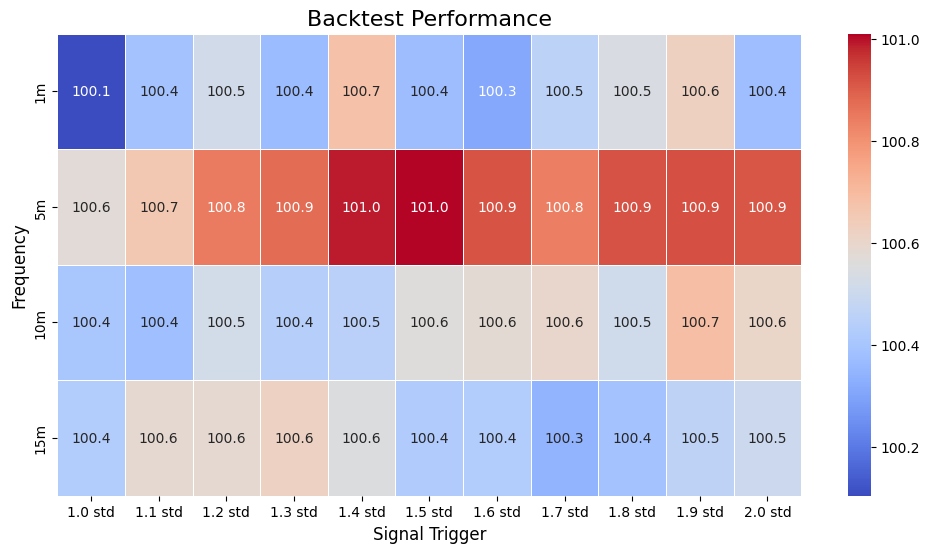

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

aggregated_res = aggregated_res.apply(pd.to_numeric, errors='coerce')
display(aggregated_res)

# plot heatmap
plt.figure(figsize=(12, 6))  # Adjust the figure size
sns.heatmap(aggregated_res, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
# Add title and labels
plt.title('Backtest Performance', fontsize=16)
plt.xlabel('Signal Trigger', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the heatmap
plt.show()

### Given the above performance, Let's see if we can improve the performance holding our position until we can flip it L->S or S->L (such that we are always holding a position)
Forward fill 0 positions such that we are always either long or short

In [20]:
stds = [float(round(std, 1)) for std in np.arange(1.0, 2.1, 0.1)]
# signal dicts houses the signal data
signal_dict = {f'{freq}m':pd.DataFrame() for freq in freqs}
position_dict = {f'{freq}m':pd.DataFrame() for freq in freqs}

# Calc Positions
for freq in spread_dict:
    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    df_copy = spread_dict[freq].copy()
    
    for std in stds:
        df_copy.loc[:, f'Position_{std} std'] = np.where(
            df_copy['Spread close'] < (df_copy['Spread Rolling Mean'] - std * df_copy['Spread Rolling Mean']), 
            1,
            np.where(df_copy['Spread close'] > (df_copy['Spread Rolling Mean'] + std * df_copy['Spread Rolling Mean']), -1, 0)
        )
        
        # Add to position dict
        posn = df_copy.loc[:, f'Position_{std} std'].shift(1).dropna().rename(f'{std} std') # shift as the positions we get is forecasting for next day
        posn.iloc[0] = 0 # Set the first position to 0
        posn = posn.replace(0.0, np.nan).ffill().replace(np.nan, 0.0)
        position_dict[freq] = pd.concat([position_dict[freq], posn], axis=1)
        # Add to signal dict
        signal_dict[freq] = pd.concat([signal_dict[freq], posn.diff().dropna().rename(f'{std} std')], axis=1)

    # Assign the modified DataFrame back to the original dictionary
    # spread_dict[freq] = df_copy
display(position_dict['1m'].head())
display(signal_dict['1m'].head())

,1.0 std,1.1 std,1.2 std,1.3 std,1.4 std,1.5 std,1.6 std,1.7 std,1.8 std,1.9 std,2.0 std
2024-11-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-01 00:02:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2024-11-01 00:04:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2024-11-01 00:06:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2024-11-01 00:07:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


,1.0 std,1.1 std,1.2 std,1.3 std,1.4 std,1.5 std,1.6 std,1.7 std,1.8 std,1.9 std,2.0 std
2024-11-01 00:02:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2024-11-01 00:04:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-01 00:06:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2024-11-01 00:07:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-01 00:08:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
capital = 100000
deployment_ratio = 0.95
for freq in freq_keys:
    for std in std_keys:
        # preprocess
        signals =  signal_dict[freq][std].rename('Signal')
        positions =  position_dict[freq][std].rename('Position')
        prices = spread_dict[freq][['USDC open', 'USDC close', 'USDT open', 'USDT close']]
        data = pd.concat([prices, signals, positions], axis=1).dropna()
        
        # run backtest
        res = run_backtest(data=data, capital=capital, deployment_ratio=deployment_ratio)
        # save in dictionary
        backtest_dict[freq][std] = res
        # save final res
        aggregated_res.loc[freq, std] = float(res.iloc[-1]['Cumulative Wealth (%)'])
        

,1.0 std,1.1 std,1.2 std,1.3 std,1.4 std,1.5 std,1.6 std,1.7 std,1.8 std,1.9 std,2.0 std
1m,100.205966,100.209945,100.340293,100.353330,100.492862,100.362771,100.447088,100.596166,100.506240,100.585048,100.606223
5m,100.502213,100.509659,100.587999,100.573113,100.354880,100.365757,100.283511,100.385128,100.325260,100.323223,100.228483
10m,100.158837,100.134206,100.246691,100.200799,100.200799,100.117377,100.255282,100.359083,100.390008,100.492375,100.492375
15m,100.381749,100.384134,100.378676,100.378676,100.384889,100.384889,100.384889,100.306605,100.351244,100.325276,100.445049


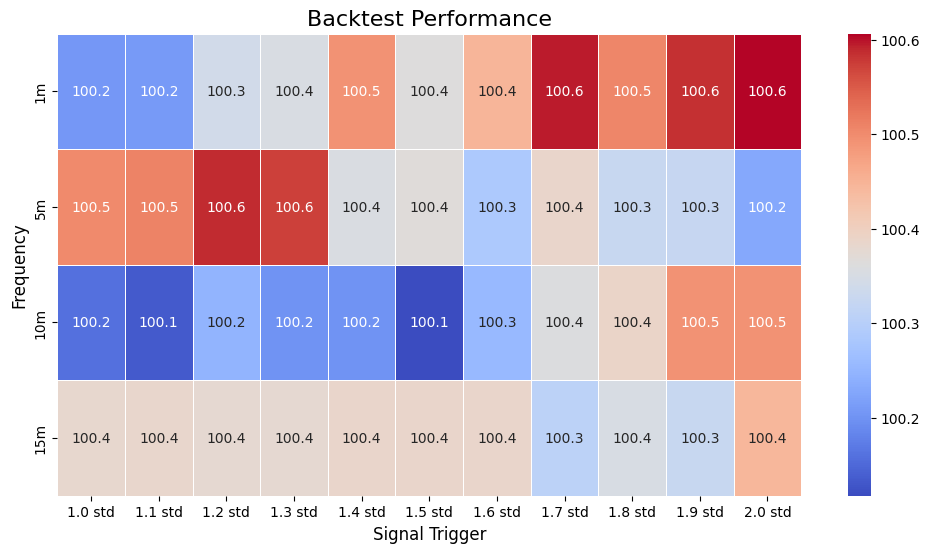

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

aggregated_res = aggregated_res.apply(pd.to_numeric, errors='coerce')
display(aggregated_res)

# plot heatmap
plt.figure(figsize=(12, 6))  # Adjust the figure size
sns.heatmap(aggregated_res, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
# Add title and labels
plt.title('Backtest Performance', fontsize=16)
plt.xlabel('Signal Trigger', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the heatmap
plt.show()

### The performance above is not as good as the original
- Given the backtest - we will work with **5 min** frequency, with triggers at **1.5 std**, using the original strategy

In [23]:
data

,USDC open,USDC close,USDT open,USDT close,Signal,Position,Cash,Cumulative Wealth,Cumulative Wealth (%)
2024-11-01 00:15:00+00:00,0.999875,1.000028,0.998680,0.998556,-1.0,-1.0,5000.0,99986.898649,99.986899
2024-11-01 00:30:00+00:00,0.999825,0.999900,0.998555,0.998701,0.0,-1.0,5000.0,99999.808832,99.999809
2024-11-01 00:45:00+00:00,0.999900,0.999850,0.998459,0.998325,0.0,-1.0,5000.0,99984.370829,99.984371
2024-11-01 01:00:00+00:00,0.999891,0.999905,0.998600,0.998450,0.0,-1.0,5000.0,99987.664599,99.987665
2024-11-01 01:15:00+00:00,1.000120,0.999995,0.998495,0.998430,0.0,-1.0,5000.0,99982.441388,99.982441
...,...,...,...,...,...,...,...,...,...
2024-11-27 23:00:00+00:00,1.000020,0.999981,1.000850,1.000945,0.0,1.0,5024.140624,100445.860058,100.44586
2024-11-27 23:15:00+00:00,0.999935,0.999804,1.000765,1.000825,0.0,1.0,5024.140624,100443.140275,100.44314
2024-11-27 23:30:00+00:00,0.999935,1.000000,1.000844,1.000850,0.0,1.0,5024.140624,100451.302662,100.451303
2024-11-27 23:45:00+00:00,1.000039,1.000098,1.000900,1.000900,0.0,1.0,5024.140624,100453.569601,100.45357
